In [55]:
import pandas as pd
import numpy as np

In [56]:
df = pd.read_csv("all_props.csv", na_values=[""])


# Save to a CSV file
molecules = df['Symbol'].values


molecules = molecules
molecules

array(['Ga', 'Cu', 'Ag', 'Pd', 'In', 'Pr', 'Mg', 'Ce', 'Sb', 'Cd', 'Al',
       'P', 'Li', 'Al', 'S', 'Mg', 'Tc', 'Ca', 'In', 'Si', 'Li', 'Li',
       'Pb', 'C', 'Li', 'C', 'Sn', 'Lu', 'Ca', 'Mg', 'Fe', 'Rh', 'Tl',
       'Yb', 'Au', 'Li', 'B', 'Nb', 'Hg', 'Ge', 'Hf', 'Si', 'Mg', 'Si',
       'Zr', 'Tl', 'Zn', 'Mg', 'Al', 'Hg', 'Fe', 'Mg', 'Mg', 'Mg', 'Pt',
       'S', 'Tl', 'Cd', 'Mg', 'Ca', 'In', 'Tm', 'In', 'Cu', 'O', 'Sn',
       'Ag', 'Au', 'Mg', 'Zn', 'Hg', 'Hf', 'Ag', 'Mg', 'Pr', 'Se', 'Si',
       'Mg', 'Pb', 'Li', 'Hg', 'O', 'C', 'Yb', 'Eu', 'W', 'Ho', 'Rh',
       'Co', 'Li', 'Mg', 'Ir', 'Tb', 'Si', 'Mg', 'Ga', 'Pb', 'Mg', 'Tb',
       'Gd', 'Br', 'Li', 'Co', 'Ac', 'Bi', 'Mg', 'Mg', 'Pd', 'O', 'Yb',
       'Pb', 'As', 'Ni', 'Eu', 'B', 'Mg', 'Mg', 'Np', 'Au', 'Sb', 'S',
       'B', 'Ge', 'Cu', 'Ga', 'Si', 'Ge', 'Nd', 'Cl', 'As', 'Sn', 'Sm',
       'F', 'O', 'Si', 'Hg', 'Re', 'B', 'Y', 'Pd', 'As', 'Mg', 'Te', 'C',
       'Cd', 'Mg', 'Ga', 'Y', 'Mg', 'S', 'Mg', 'Tl', 'Ga', 'Mg',

In [57]:
df.drop(columns=['Symbol','results_per_total','results_per_li','results_per_counter_ion','AtomicMass'], inplace=True)

In [58]:
df['Sqrt_pol'] = np.sqrt(df['Polarizability'])

In [59]:
df

,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,LiSites,CounterIonSites,Sqrt_pol
0,187.0,1.81,5.999,0.300,50.00,1.0,3.0,7.071068
1,140.0,1.90,7.726,1.228,46.50,2.0,6.0,6.819091
2,172.0,1.93,7.576,1.302,55.00,1.0,1.0,7.416198
3,202.0,2.20,8.337,0.557,26.14,3.0,1.0,5.112729
4,193.0,1.78,5.786,0.300,65.00,3.0,1.0,8.062258
...,...,...,...,...,...,...,...,...
447,196.0,1.62,6.108,0.200,66.00,1.0,3.0,8.124038
448,236.0,0.00,5.550,0.000,200.00,1.0,3.0,14.142136
449,173.0,1.31,7.646,0.000,71.20,1.0,149.0,8.438009
450,209.0,2.28,9.000,2.128,48.00,3.0,1.0,6.928203


### making the combinations

In [60]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

In [61]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]

            # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue

            # Select the subset DataFrame
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results


In [62]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names, restricted_properties=None, restricted_to_inverses=None):
    if restricted_properties is None:
        restricted_properties = []
    if restricted_to_inverses is None:
        restricted_to_inverses = []

    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

     # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})
    
    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):
            subset_names = [combined_param_names[i] for i in subset_indices]

            # Replace NaN values with 0
             # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue
            
            subset = combined_params_df[subset_names]
            subset = subset.fillna(0)

            # Check if both a parameter and its inverse are in the subset
            invalid = False
           
            # Exclude subsets containing restricted inverses
            for restricted in restricted_properties:
                if f"{restricted}^(-1)" in subset_names:
                    invalid = True
                    break

            # Ensure restricted properties only appear as inverses
            for restricted in restricted_to_inverses:
                if restricted in subset_names or (restricted not in param_names and f"{restricted}^(-1)" not in subset_names):
                    invalid = True
                    break

            if invalid:
                continue

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))
            expr_str = " + ".join(subset_names)
            expr_val = subset.sum(axis=1)
            results.append((expr_str, expr_val))

    return results


In [63]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

def process_combinations_chunk(args):
    combined_params_df, combined_param_names, param_names, indices_chunk = args
    results = []

    for indices in indices_chunk:
        subset_names = [combined_param_names[i] for i in indices]
        subset = combined_params_df[subset_names]

        # Replace NaN values with 0
        subset = subset.fillna(0)

        # Check if both a parameter and its inverse are in the subset
        invalid = False
        for name in subset_names:
            if name.endswith("^(-1)") and name[:-5] in subset_names:
                invalid = True
                break
            elif name in param_names and f"{name}^(-1)" in subset_names:
                invalid = True
                break

        if not invalid:
            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

def generate_combinations_df_parallel(params_df, param_names):
    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameter indices
    all_combinations = [
        indices for r in range(1, len(combined_param_names) + 1)
        for indices in itertools.combinations(range(len(combined_param_names)), r)
    ]

    # Divide all_combinations into chunks
    num_workers = min(cpu_count(), len(all_combinations))
    chunk_size = max(1, len(all_combinations) // num_workers)
    chunks = [all_combinations[i:i + chunk_size] for i in range(0, len(all_combinations), chunk_size)]

    print(f"Using {num_workers} workers to process {len(all_combinations)} combinations in {len(chunks)} chunks")

    # Prepare arguments for parallel processing
    args = [
        (combined_params_df, combined_param_names, param_names, chunk)
        for chunk in chunks
    ]

    # Use multiprocessing to process combinations in parallel
    with Pool(processes=num_workers) as pool:
        results = pool.map(process_combinations_chunk, args)

    # Flatten results
    flattened_results = [item for sublist in results for item in sublist]
    return flattened_results


### Running Combinations

In [64]:
numeretor = ['Polarizability']
denomeretor = ['AtomicRadius']
numeretor = None
denomeretor = None

In [65]:

import os
import pandas as pd

takeSaved = False

all_expressions = []
expressions = []
# Define file name to save/load the results
cache_file = "cached_expressions.pkl"

if os.path.exists(cache_file) and takeSaved:
    # Load the cached results if they exist
    expressions = pd.read_pickle(cache_file)
    all_expressions = list(expressions.itertuples(index=False, name=None))
    print("Loaded cached expressions.")
else:
    # Perform the costly computation if cache does not exist
    print("Calculating expressions...")
    param_names = list(df.columns)
    all_expressions = generate_combinations_df(df.iloc[:,:], param_names, restricted_properties=numeretor, restricted_to_inverses=denomeretor)
    expressions = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

    # Save the results to cache
    expressions.to_pickle(cache_file)
    print("Expressions cached.")

# Print the shape of the expressions DataFrame
print(expressions.shape)


Calculating expressions...


C:\Users\user\AppData\Local\Temp\ipykernel_18236\1368268208.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)


Expressions cached.
(13120, 2)


In [66]:
expressions['Value'] = expressions['Value'] 
expressions.head()

,Expression,Value
0,AtomicRadius,0 187.0 1 140.0 2 172.0 3 ...
1,AtomicRadius,0 187.0 1 140.0 2 172.0 3 ...
2,Electronegativity,0 1.81 1 1.90 2 1.93 3 2.2...
3,Electronegativity,0 1.81 1 1.90 2 1.93 3 2.2...
4,IonizationEnergy,0 5.999 1 7.726 2 7.576 3 ...


### Addition results to the combinations

In [67]:
values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
values['res'] = pd.read_csv("all_props.csv", na_values=[""])['results_per_total'].values

In [68]:

correlation = values.corr()

correlation.shape

(13105, 13105)

In [69]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:100])
top_vars = results.iloc[1:100].index

res                                                                                                                      1.000000
AtomicRadius * Electronegativity                                                                                         0.622178
Electronegativity                                                                                                        0.620298
Electronegativity + AtomicRadius^(-1)                                                                                    0.620250
Electronegativity + IonizationEnergy^(-1)                                                                                0.619416
                                                                                                                           ...   
Electronegativity + IonizationEnergy + AtomicRadius^(-1) + ElectronAffinity^(-1) + LiSites^(-1) + Sqrt_pol^(-1)          0.591078
Electronegativity + IonizationEnergy + ElectronAffinity^(-1) + Polarizability^(-1) + LiSit

In [70]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:200])
top_vars = results.iloc[1:200].index


res                                                                                                                                1.000000
AtomicRadius * Electronegativity                                                                                                   0.622178
Electronegativity                                                                                                                  0.620298
Electronegativity + AtomicRadius^(-1)                                                                                              0.620250
Electronegativity + IonizationEnergy^(-1)                                                                                          0.619416
                                                                                                                                     ...   
ElectronAffinity + Polarizability + Sqrt_pol + IonizationEnergy^(-1)                                                               0.584967
Polarizability + Ato

In [71]:
param = top_vars[0]

y = values[param]
x = values['res']

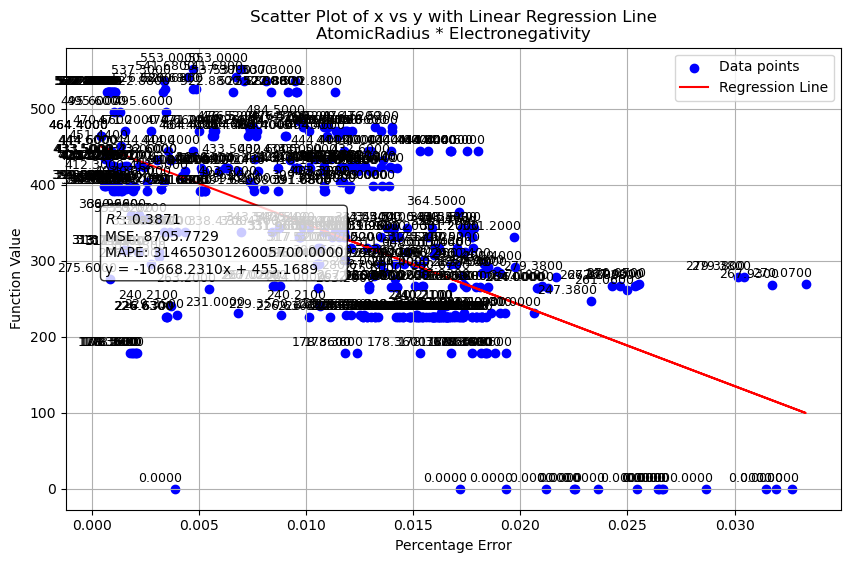

In [72]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Reshape x to a 2D array
x_reshaped = x.values.reshape(-1, 1)  # Convert x to a 2D array (n, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x_reshaped, y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]  # model.coef_ gives the slope of the line
intercept = model.intercept_  # model.intercept_ gives the intercept

# Predict y values using the linear model
y_pred = model.predict(x_reshaped)

# Calculate R^2, MSE, and MAPE
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)

# Display the equation of the line
equation = f"y = {slope:.4f}x + {intercept:.4f}"

# Plot the data points and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_pred, color='red', label='Regression Line')
plt.title(f'Scatter Plot of x vs y with Linear Regression Line\n{param}')
plt.xlabel('Percentage Error')
plt.ylabel('Function Value')
plt.grid()
plt.legend()

for i in range(len(x)):
    plt.annotate(f"{y.iloc[i]:.4f}", (x.iloc[i], y.iloc[i]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9)

# Add text box with metrics
textstr = f"$R^2$: {r_squared:.4f}\nMSE: {mse:.4f} \nMAPE: {mape:.4f}\n{equation}"
plt.gca().text(0.05, 0.65, textstr, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.show()